# Objective
Notebook provides a pipeline to compare the results of the simulation model against the true model discovered from the original eventlog

In [116]:
import simpy
from outputs.run_definition import run_definition 
import outputs.process_class as pc
from outputs.utils import process_path_probability
import pickle
import pandas as pd
import pm4py
from pm4py.statistics.variants.log import get as pml
from pm4py.objects.conversion.log.variants import df_to_event_log_nv 

# For simulation

In [117]:
env = simpy.Environment()

with open('outputs/data/variants.pkl', 'rb') as f:
     variants = pickle.load(f)


process_scenario_object = pc.process_definition(env)
process_path_probabilities = process_path_probability(variants).run()
event_log = process_scenario_object.log_list

with open('outputs/data/log_sim.pkl', 'wb') as f:
     pickle.dump(event_log, f)

    
env.process(run_definition(env, process_scenario_object,  process_path_probabilities))
env.run(500)



In [118]:
log_sim_pm = pd.DataFrame(event_log, columns = ['entity' , 'event_time', 'Activity'])
log_pm = pm4py.format_dataframe(log_sim_pm, case_id = 'entity', activity_key = 'Activity', timestamp_key = 'event_time')

In [119]:
log_pm

,case:concept:name,time:timestamp,concept:name,@@index
35,10,20,register_request,35
52,10,28,check_ticket,52
60,10,32,examine_casually,60
64,10,34,decide,64
68,10,36,pay_compensation,68
...,...,...,...,...
54,9,30,reinitiate_request,54
59,9,32,examine_thoroughly,59
84,9,42,check_ticket,84
103,9,48,decide,103


In [120]:
process_mode = pm4py.discover_bpmn_inductive(log_pm)

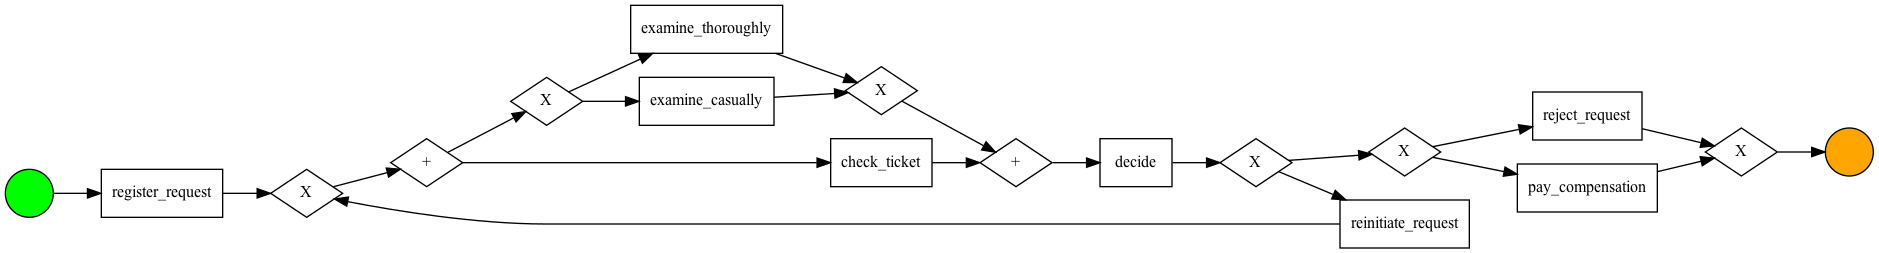

In [121]:
pm4py.view_bpmn(process_mode)

In [122]:
event_log_renamed = log_pm

In [123]:
event_log_renamed

,case:concept:name,time:timestamp,concept:name,@@index
35,10,20,register_request,35
52,10,28,check_ticket,52
60,10,32,examine_casually,60
64,10,34,decide,64
68,10,36,pay_compensation,68
...,...,...,...,...
54,9,30,reinitiate_request,54
59,9,32,examine_thoroughly,59
84,9,42,check_ticket,84
103,9,48,decide,103


In [124]:
event_log_renamed_sim = df_to_event_log_nv.apply(event_log_renamed)

In [125]:
variants_simulation = pml.get_variants_sorted_by_count(pml.get_variants(event_log_renamed_sim))

In [126]:
variants_simulation

[['register_request,check_ticket,examine_thoroughly,decide,reject_request',
  10],
 ['register_request,examine_thoroughly,check_ticket,decide,reject_request', 9],
 ['register_request,examine_casually,check_ticket,decide,reinitiate_request,examine_thoroughly,check_ticket,decide,pay_compensation',
  9],
 ['register_request,examine_casually,check_ticket,decide,reinitiate_request,check_ticket,examine_casually,decide,reinitiate_request,examine_casually,check_ticket,decide,reject_request',
  9],
 ['register_request,examine_casually,check_ticket,decide,pay_compensation', 7],
 ['register_request,check_ticket,examine_casually,decide,pay_compensation', 6]]

In [79]:
# Optional: save the diagram discovered by the model

In [81]:
#pm4py.save_vis_bpmn(process_mode, '/Diagrams/simulation_model_simple_process.png')

# For original model

In [82]:
event_log = pm4py.read_xes('Dataset/running-example.xes')

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

In [83]:
event_log_pd = pm4py.convert_to_dataframe(event_log)

In [84]:
event_log_pd_filtered = event_log_pd[['case:concept:name', 'Activity', 'time:timestamp']]

In [85]:
event_log_pd_filtered.columns = ['entity', 'Activity', 'event_time']

In [86]:
variants_original = pml.get_variants_sorted_by_count(pml.get_variants(event_log))

In [87]:
log_sim_pm = pd.DataFrame(event_log_pd_filtered, columns = ['entity' , 'event_time', 'Activity'])
log_pm = pm4py.format_dataframe(log_sim_pm, case_id = 'entity', activity_key = 'Activity', timestamp_key = 'event_time')

In [88]:
process_mode = pm4py.discover_bpmn_inductive(log_pm)

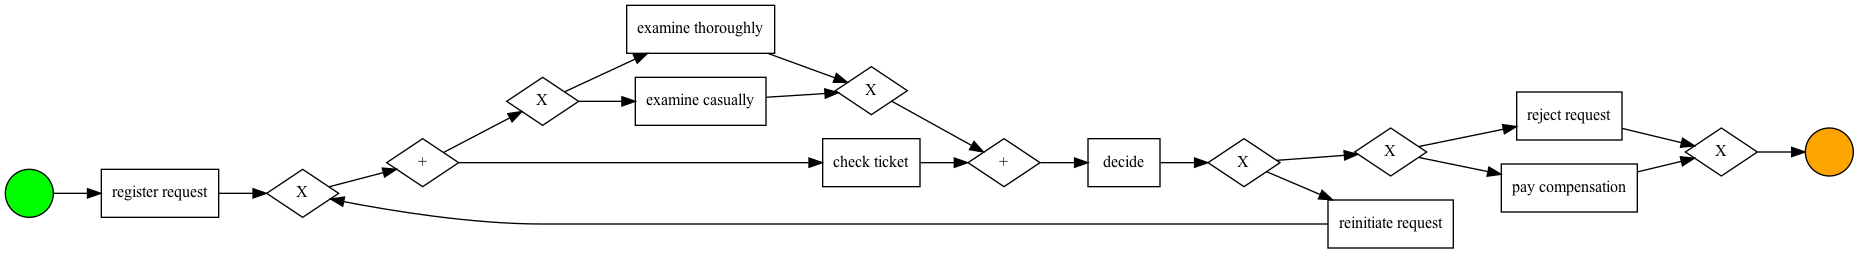

In [89]:
pm4py.view_bpmn(process_mode)

In [90]:
#pm4py.save_vis_bpmn(process_mode, '/Diagrams/original_model_simple_process.png') # command for saving the output model diagram

# Quantifying accuracy

## preprocessing

In [ ]:
## isolate all process paths from variant list and store it in a seperate list (for simulation data)

In [190]:
variants_simulation_component = []
for i in range(len(variants_simulation)):
    variants_simulation_component.append(variants_simulation[i][-2]) 

In [ ]:
## isolate all process paths from variant list and store it in a seperate list (for original data). 

In [191]:
variants_original_component = []
for i in range(len(variants_simulation)):
    variants_original_component.append(variants_original[i][-2]) 

In [193]:
for j in range(len(variants_original_component)):
     variants_original_component[j] = variants_original_component[j].replace(' ', '_')

In [ ]:
## Measure

In [196]:
count_true_positives = 0
for variant in variants_simulation_component:
    if variant in variants_original_component:
        count_true_positives = count_true_positives + 1

In [197]:
T_P_T_real = (count_true_positives/len(variants_original))*100

In [198]:
T_N_T_real = ((len(variants_simulation) - count_true_positives)/len(variants_original))*100

In [199]:
T_P_T_sim = (count_true_positives/len(variants_simulation))*100

In [200]:
T_N_T_sim = ((len(variants_simulation) - count_true_positives)/len(variants_simulation))*100

count of variants that did not show in the simulation

In [201]:
variants_left = ((len(variants_original) - count_true_positives)/len(variants_original))*100 # count of variants that did not show in the simulation

In [202]:
T_P_T_real = (count_true_positives/len(variants_original))*100

In [203]:
count_true_positives

6

In [204]:
T_N_T_real

0.0

In [205]:
T_P_T_sim

100.0

In [206]:
T_N_T_sim

0.0

In [207]:
variants_left

0.0